# Solve the problems statement made in part 1 using a stock optimizer

1. Begin by importing data and libraries. Define starting and ending points

starting index: (2835, 2271)
ending index: (1335, 1483)

Start Location: (40.09047158688756, -76.91653014622179, 152.42)
End Location: (40.10366175255552, -76.92595521393523, 411.659)


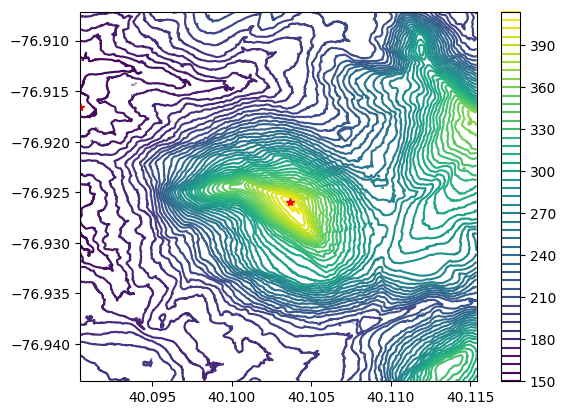

In [6]:
import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt

import little_roundtop_mountain_data_and_plot.import_tar_file_extract_tif as tar
import little_roundtop_mountain_data_and_plot.extract_and_plot_lat_lon_elevation_data as elv

#Create max and min index functions
get_max_index = lambda x: np.unravel_index(np.argmax(x), x.shape)
get_min_index = lambda x: np.unravel_index(np.argmin(x), x.shape)

# Find the current starting and ending points
start  = get_min_index(elv.elevation)
end = get_max_index(elv.elevation)

print(f"starting index: {start}")
print(f"ending index: {end}\n")

# Given the index of a point, finds the lat,lon,elevation
def get_location(point):
    
    # Extract indicies from our point
    x_indx = point[0]
    y_indx = point[1]

    # return tuple (lat, long, elevation)
    return elv.lat[x_indx][y_indx], elv.lon[x_indx][y_indx], elv.elevation[x_indx][y_indx]

# find geographic location of start and end points
start_loc = get_location(start)
end_loc = get_location(end)

# make the function that interpolates elevation

def get_elevation(lat, lon):

    try:
        # Map the input latitude and longitude to the indices of the elevation array
        i = int(np.interp(lat, (elv.minY, elv.maxY), (elv.elevation.shape[0]-1, 0)))
        j = int(np.interp(lon, (elv.minX, elv.maxX), (0, elv.elevation.shape[1]-1)))
        # Use bilinear interpolation to estimate the elevation at the given point
        x1, x2 = lon, lon+elv.transform[0]
        y1, y2 = lat, lat+elv.transform[4]
        q11, q21 = elv.elevation[i,j], elv.elevation[i,j+1]
        q12, q22 = elv.elevation[i+1,j], elv.elevation[i+1,j+1]
        elevation_at_point = ((q11 * (x2 - lon) * (y2 - lat) + 
                                q21 * (lon - x1) * (y2 - lat) + 
                                q12 * (x2 - lon) * (lat - y1) + 
                                q22 * (lon - x1) * (lat - y1)) / ((x2 - x1) * (y2 - y1)))
    
    except:

        return 150.

    return elevation_at_point


print(f"Start Location: {start_loc}")
print(f"End Location: {end_loc}")
plt.figure(1)
plt.contour(elv.lat, elv.lon, elv.elevation,50)
plt.plot(start_loc[0],start_loc[1], '*r')
plt.plot(end_loc[0], end_loc[1], "r*")
plt.colorbar()

2. Then define constraint functions and objective functions

In [13]:
# Just a bunch of helper functions -------------------------------------

# Given x vector, returns points that it expresses
def get_points(x):

    points = []

    for i in range(0, len(x), 2):

        xi = x[i]
        yi = x[i+1]
        zi = get_elevation(xi, yi)

        points.append((xi, yi, zi))

    return points




# Finds distance between two points
def get_len(point1, point2):

    dx = point2[0] - point1[0]
    dy = point2[1] - point1[1]
    dz = point2[2] - point1[2]

    return np.linalg.norm(np.array([dx ,dy , dz]))

# given two points, finds the slope of the 
def get_slope(point1, point2):

    dx = point2[0] - point1[0]
    dy = point2[1] - point1[1]
    dz = point2[2] - point1[2]

    run = np.linalg.norm(np.array([dx, dy]))

    rise = dz
    
    return rise/run

    

# Given the x vector, returns the path
def get_path(x):

    x_points = get_points(x)

    path = []

    path.append(start_loc)

    path.extend(x_points)

    path.append(end_loc)

    return path

# Given x vector, returns path length
def get_path_length(x):

    path = get_path(x)

    length = 0

    for i in range(0, len(path) - 1):

        point1 = path[i]
        point2 = path[i + 1]

        length += get_len(point1, point2)

    return length
    
    
# Given the x vector, returns the sum total
# of absolute values of slopes

MAX_SLOPE = 9e4

def get_total_slopes(x):

    path = get_path(x)

    sum_slopes = 0

    for i in range(0 , len(path) - 1):

        point1 = path[i]
        point2 = path[i + 1]

        slope = get_slope(point1, point2)

        # if np.abs(slope) >= MAX_SLOPE:

        #     slope = np.inf

        sum_slopes += np.abs(slope)

    return sum_slopes

# Actual Code ---------------------------------------------
WEIGHT_SLOPE = 2.5 # weight for slope in cost function
WEIGHT_LEN = 100.0 # weight for length in cost function

def objective_function(x):


    return WEIGHT_LEN * get_path_length(x) + WEIGHT_SLOPE*get_total_slopes(x)

def contraint_function(x):

    slopes = []
    
    path = get_path(x)

    for i in range(0 , len(path) - 1):


        point1 = path[i]
        point2 = path[i + 1]

        slope = get_slope(point1, point2)

        slopes.append(slope)


    return MAX_SLOPE - np.array(slopes)

constraints = [
                {'type':'ineq','fun': lambda x: contraint_function(x)}
              ]   

bounds = opt.Bounds(lb=[elv.minY, elv.minX], ub=[elv.maxY, elv.maxX])


3. Plug into stock optimizer and print results

 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 73301.68211776389
       x: [ 4.009e+01 -7.692e+01]
     nit: 1
     jac: [ 2.743e+11 -7.785e+05]
    nfev: 3
    njev: 1
[40.09047158688756, 40.090454, 40.10366175255552]
[-76.91653014622179, -76.92, -76.92595521393523]


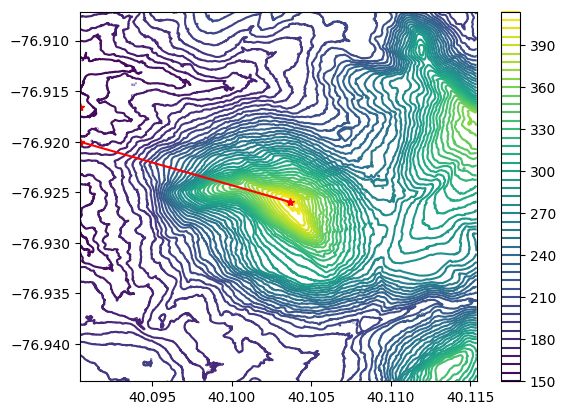

In [20]:
result = opt.minimize(objective_function, [40.011, -76.92], constraints = constraints, bounds=bounds)
print(result)

final_path = get_path(result.x) # extract the path of the final result

plt.figure(1)
plt.contour(elv.lat, elv.lon, elv.elevation,50)
plt.colorbar()

path_x = []
path_y = []

for i in range(0, len(final_path)):

    path_x.append(final_path[i][0])
    path_y.append(final_path[i][1])

print(path_x)
print(path_y)

plt.plot(path_x, path_y, "r*-")

4. Extract Metrics and Iterate